In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict

In [2]:
def preprocess(train, isTrain=True):
    # extract review value
    train.Reviews = train.Reviews.apply(lambda x: float(x[:3]) )
    
    # first word is num ratings
    train.Ratings = train.Ratings.apply(
        lambda x: float(
                    x.split()[0].replace(',','')
                )
    )

    # for Edition just check if Hardcover is there
    train.Edition = train.Edition.apply(lambda x: 1 if 'Hardcover' in x else 0)

    features = 'Author Genre BookCategory Reviews Ratings Edition'.split()
    if isTrain:
        # train.Price = train.Price.apply(np.log)
        features.append('Price')

    return train[features]

def categoricalToIndices(train, test):
    catFeatures = 'Author Genre BookCategory'.split()
    for col in catFeatures:
        trainTypes = set(train[col]) 
        testTypes  = set(test[col])

        # use the intersection for resolving indices
        common = trainTypes.intersection(testTypes)
        types = list(common)
        types.sort()
        wordIdx = defaultdict(lambda: 0)
        for i, t in enumerate(types):
            wordIdx[t] = i+1
        train[col] = train[col].apply(lambda x: wordIdx[x])
        test[col]  = test[col] .apply(lambda x: wordIdx[x])

In [3]:
train = pd.read_excel('Data_Train.xlsx')
test = pd.read_excel('Data_Test.xlsx')

procTrain = preprocess(train.copy(), isTrain=True)
procTest  = preprocess(test.copy(), isTrain=False)

categoricalToIndices(procTrain, procTest)

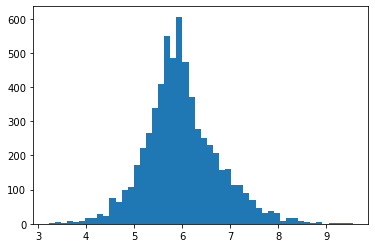

In [4]:
_ = plt.hist(procTrain.Price, bins=50)

In [5]:
procTrain.head()

,Author,Genre,BookCategory,Reviews,Ratings,Edition,Price
0,0,2,1,4.0,8.0,0,5.393628
1,37,50,3,3.9,14.0,0,5.312861
2,0,126,7,4.8,6.0,0,5.700444
3,8,64,6,4.1,13.0,0,5.192957
4,0,157,2,5.0,1.0,1,6.872770


In [6]:
# for Edition just check if Hardcover is there
for model in 'Paperback Hardcover'.split():
    idx = train.Edition.apply(lambda x: model in x)
    avg = train.Price[idx].mean()
    std = train.Price[idx].std()
    print(model.ljust(12), round(avg, 3), round(std, 3))

avg, std = train.Price.mean(), train.Price.std()
print("Overall".ljust(12), round(avg, 3), round(std, 3))

Paperback    490.839 524.795
Hardcover    983.294 1170.782
Overall      560.708 690.111


In [7]:
def get_common_unk(common, values):
    present = values.apply(lambda t: t in common)
    x =  present.sum() / len(present)
    x = round(x, 3)
    return str(x).ljust(8)

def overlap(col):
    a = set(train[col])
    b = set(test[col])

    common = a.intersection(b)
    return get_common_unk(common, train[col]), get_common_unk(common, test[col])

print("-"*33)
print("Column".ljust(15), "train".ljust(8), "test", sep="| ")
print("-"*33)
for col in 'Author Genre BookCategory'.split():
    vals = overlap(col)
    print(col.ljust(15), *vals, sep="| ")
print("-"*33)

---------------------------------
Column         | train   | test
---------------------------------
Author         | 0.341   | 0.54    
Genre          | 0.952   | 0.985   
BookCategory   | 1.0     | 1.0     
---------------------------------
